## Block maxima

In [1]:
import warnings
warnings.filterwarnings('ignore')

from pandas_datareader import DataReader
from datetime import datetime

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [9,8]

import numpy as np
import pandas as pd
from scipy import integrate

In [2]:
start = datetime(2005,1,1)
end = datetime(2010,12,31)

ge = DataReader('GE', 'yahoo',start, end)['Close']
returns = np.log(ge).diff().dropna() # log returns
returns = returns.loc['2007-01-01':'2009-12-31']
losses = - returns

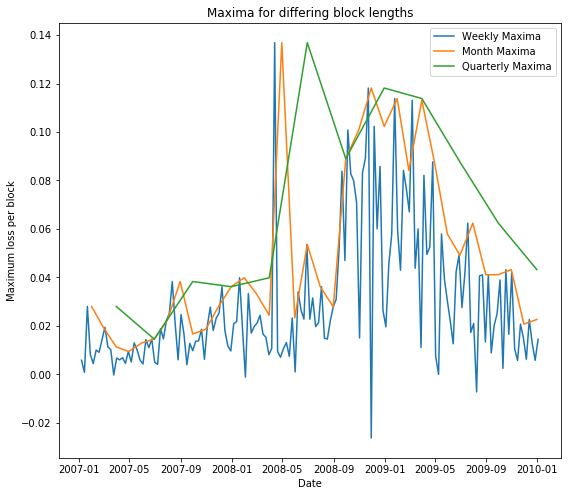

In [3]:
# Resample the data into weekly blocks
weekly_maxima = losses.resample('W').max()

# Resample the data into monthly blocks
monthly_maxima = losses.resample('M').max()

# Resample the data into quarterly blocks
quarterly_maxima = losses.resample('Q').max()

# Plot the resulting weekly, monthly and quarterly maxima
plt.plot(weekly_maxima, label="Weekly Maxima")
plt.plot(monthly_maxima, label="Month Maxima")
plt.plot(quarterly_maxima, label="Quarterly Maxima")

# Create legend and plot
plt.xlabel('Date')
plt.ylabel('Maximum loss per block')
plt.title('Maxima for differing block lengths')
plt.legend()
plt.show()

GE's losses were high and volatile during the crisis. Concentrating on the block maxima provides information about the tail of the loss distribution, which is critical for risk management.

## Extreme events during the crisis

We can use the Generalized Extreme Value (GEV) distribution to examine extreme values in the losses of General Electric (GE) during the financial crisis in 2008 and 2009.

This period coincided with GE's liquidity crisis, and its eventual requirement of an emergency investment of $3 billion from Berkshire Hathaway's Warren Buffet to stave off defaulting on its commercial paper obligations.

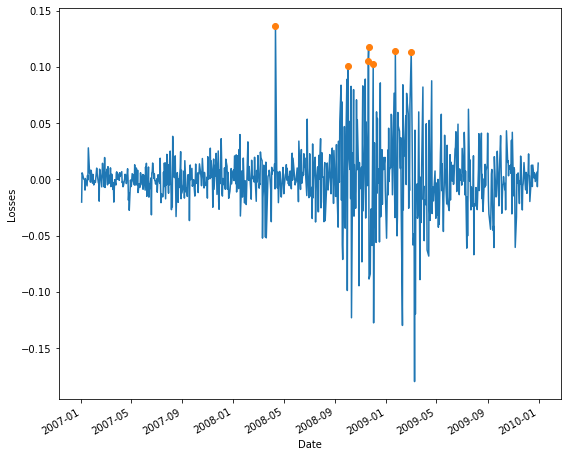

In [4]:
# Plot the log daily losses of GE over the period 2007-2009
losses.plot()

# Find all daily losses greater than 10%
extreme_losses = losses[losses>0.1]

# Scatter plot the extreme losses
extreme_losses.plot(style='o')
plt.xlabel('Date')
plt.ylabel('Losses')
plt.show()

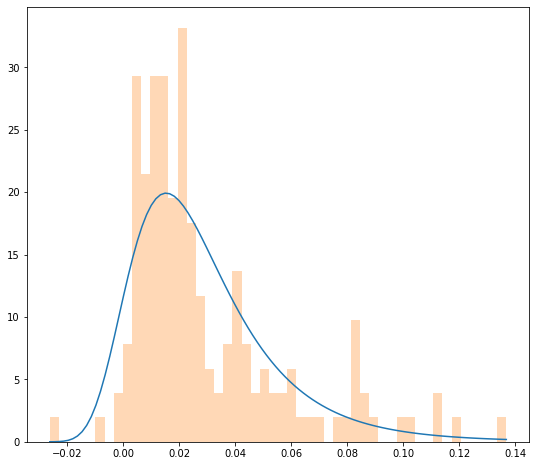

In [5]:
from scipy.stats import genextreme

# Fit extreme distribution to weekly maximum of losses
fitted = genextreme.fit(weekly_maxima)

# Plot extreme distribution with weekly max losses historgram
x = np.linspace(min(weekly_maxima), max(weekly_maxima), 100)
plt.plot(x, genextreme.pdf(x, *fitted))
plt.hist(weekly_maxima, 50, density = True, alpha = 0.3)
plt.show()

We've successfully fit returns data to an extreme value distribution for the financial crisis period. GE would survive the crisis, but would not remain unscathed.

## GEV risk estimation

Suppose that we were holding € 1,000,000 of GE stock on January 1, 2010. We would like to cover the expected maximum losses that might occur over the next week, based upon available data from the previous two years, 2008 - 2009. We assume that maximum weekly losses for GE are distributed according to a Generalized Extreme Value (GEV) distribution.

To model expected losses we'll estimate the CVaR at the 99% confidence level for the GEV distribution, and use it to compute the amount needed in reserve to cover the expected maximum weekly loss over January, 2010.

In [6]:
# Compute the 99% VaR (needed for the CVaR computation)
VaR_99 = genextreme.ppf(0.99, *fitted)

# Compute the 99% CVaR estimate
CVaR_99 = (1 / (1 - 0.99)) * genextreme.expect(lambda x: x, 
           args=(fitted[0],), loc = fitted[1], scale = fitted[2], lb = VaR_99)

# Display the covering loss amount
print("Reserve amount: ", 1000000 * CVaR_99)

Reserve amount:  147797.23449737357


To cover the expected maximum weekly loss you'd need a reserve of roughly 15% of the portfolio value, which is significant. Although the financial crisis was largely over by 2010, new international regulations were implemented requiring higher reserves for banks and institutional investors using both the VaR and CVaR risk measures.

## KDE of a loss distribution

In principle, kernel density estimation (KDE) can fit distributions with 'fat tails', i.e. distributions with occasionally large deviations from the mean (such as the distribution of portfolio losses).

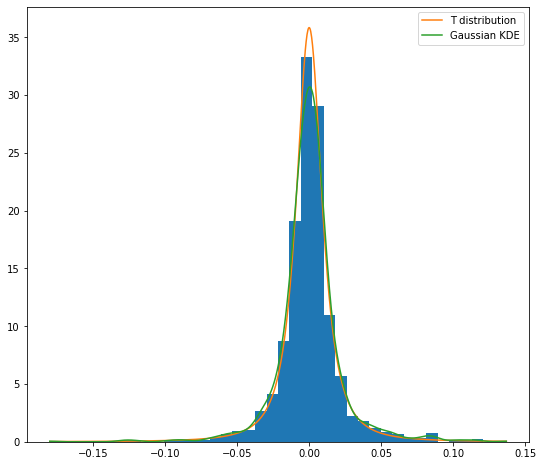

In [7]:
# Import the Student's t-distribution
from scipy.stats import t
from scipy.stats import gaussian_kde

returns = np.log(ge).diff().dropna() # log returns
losses = - returns

# Generate a fitted T distribution over losses
params = t.fit(losses)

# Generate a Gaussian kernal density estimate over losses
kde = gaussian_kde(losses)

# Add the PDFs of both estimates to a histogram, and display
x = np.linspace(np.min(losses), np.max(losses), 1000)
plt.hist(losses, 40, density = True)
plt.plot(x, t.pdf(x, *params), label = 'T distribution')
plt.plot(x, kde.pdf(x), label = 'Gaussian KDE')
plt.legend(); plt.show()

Both estimates fit the portfolio data better than a Normal distribution. In this example, while the T fits the peak of the data histogram better, the Gaussian KDE fits the tails better. Both parametric and non-parametric estimation are used extensively in statistics and risk management. The T and Gaussian KDE estimates are both good fits, each in a different way: the T captures the peak well, while the KDE captures the tails better.

## Which distribution?

It's often hard to initially select how to represent a loss distribution. A visual comparison between different fitted distributions is usually a good place to start. The T and Gaussian KDE estimates are both good fits, each in a different way: the T captures the peak well, while the KDE captures the tails better.

## CVaR and loss cover selection

We saw that both the T and the Gaussian KDE distributions fit portfolio losses for the crisis period fairly well. Given this, which of these is best for risk management? One way to choose is to select the distribution that provides the largest loss cover, to cover the "worst worst-case scenario" of losses.

In [8]:
# Function to calculate expected KDE
def expectKDE(func, lb = -np.inf):
  return integrate.quad(lambda y: func(y) * kde.pdf(y), a = lb, b = np.inf)[0]

In [9]:
returns = np.log(ge).diff().dropna() # log returns
returns = returns.loc['2007-01-01':'2008-12-31']
losses = - returns

# Generate a fitted T distribution over losses
params = t.fit(losses)

# Generate a Gaussian kernal density estimate over losses
kde = gaussian_kde(losses)

# Find the VaR as a quantile of random samples from the distributions
VaR_99_T   = np.quantile(t.rvs(size=1000, *params), 0.99)
VaR_99_KDE = np.quantile(kde.resample(size=1000), 0.99)

# Find the expected tail losses, with lower bounds given by the VaR measures
integral_T = t.expect(lambda x: x, args = (params[0],), loc = params[1], scale = params[2], lb = VaR_99_T)
integral_KDE = expectKDE(lambda x: x, lb = VaR_99_KDE)

# Create the 99% CVaR estimates
CVaR_99_T   = (1 / (1 - 0.99)) * integral_T
CVaR_99_KDE = (1 / (1 - 0.99)) * integral_KDE

# Display the results
print("99% CVaR for T: ", CVaR_99_T, "; 99% CVaR for KDE: ", CVaR_99_KDE)

99% CVaR for T:  0.17312199599539216 ; 99% CVaR for KDE:  0.11654123859107812


As we can see, the T distribution returns a larger estimated CVaR, although the KDE estimate is smaller. In any case, using the T distribution's 99% CVaR estimate to specify a reserve amount ensures both possible maximum expected losses are covered.